## 1 Functions and module

In [3]:
import pandas as pd
import gzip
import glob
import os
import subprocess

In [4]:
import subprocess

def get_fastq_read_count(fastq_gz_path):
    """
    Returns the total number of reads in a gzipped FASTQ file
    by counting lines (4 lines per read).
    """
    # Construct the shell command
    cmd = f"zcat {fastq_gz_path} | wc -l"
    
    # Execute the command and capture output
    line_count_str = subprocess.check_output(cmd, shell=True).decode().strip()
    line_count = int(line_count_str)
    
    # Each FASTQ read = 4 lines
    read_count = line_count // 4
    return read_count


## 2 Input and output address

In [5]:
parental_address = '/labs/mwinslow/Haiqing/UltraSeq_Projects/Kat7_dual_guide_tumor'

In [6]:
raw_read_input_address = parental_address + '/01_data_collection/data/NGS_address'

In [7]:
summary_df_output_address  = parental_address + '/01_data_collection/data/reads_distribution_summary.csv'

In [8]:
fig_output_address  = parental_address + '/01_data_collection/fig/sorted_read_fractions_and_totals.pdf'

## 3 Get raw read counts

In [9]:
raw_read_input = pd.read_csv(raw_read_input_address,sep = '\t')

In [10]:
raw_read_input = pd.read_csv(raw_read_input_address, sep=',', header=None, names=['Address_r1', 'Address_r2', 'Sample_ID'])


In [11]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID
0,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_10
1,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_26
2,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_11
3,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_25
4,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_17


In [12]:
# Take each file path from Address_r1.
# Run get_fastq_read_count(...) on it.
# Store the resulting integer in total_raw_reads.
raw_read_input['total_raw_reads'] = raw_read_input['Address_r1'].apply(get_fastq_read_count)


## 4 Get extracted read counts

In [13]:
# Lists to store counts of parsed reads and matched the flanking sequence pattern
unexpected_reads_with_guides = [] # Subset of reads_with_guides that also have an unexpected gRNA/or gRNA like sequence         
expected_reads_with_guides = [] # Subset of reads_with_guides that also have an expected gRNA

for sample_id in raw_read_input["Sample_ID"]:
    unexpected_csv = f"{parental_address}/01_data_collection/data/Bartender/{sample_id}/Unexpected_reads.csv"
    intermediate_csv = f"{parental_address}/01_data_collection/data/Bartender/{sample_id}/Intermediate_df.csv"
    
    # Count lines (subtract 1 to account for header row)
    unexpected_count = int(os.popen(f"wc -l < {unexpected_csv}").read().strip()) - 1
    expected_count = int(os.popen(f"wc -l < '{intermediate_csv}'").read().strip()) - 1
    
    # Handle potential negative counts if file is empty
    unexpected_reads_with_guides.append(max(unexpected_count, 0))
    expected_reads_with_guides.append(max(expected_count, 0))



In [14]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID,total_raw_reads
0,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_10,3860436
1,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_26,8284136
2,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_11,409812
3,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_25,3532106
4,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_17,3384786


In [15]:
# Assign read counts to the DataFrame
raw_read_input['unexpected_reads_with_guides'] = unexpected_reads_with_guides
raw_read_input['expected_reads_with_guides'] = expected_reads_with_guides

# 'lowQ_reads' represent reads removed by adapter removal or those that cannot extract guides/barcodes
raw_read_input['lowQ_reads'] = (
    raw_read_input['total_raw_reads'] - raw_read_input['unexpected_reads_with_guides'] - raw_read_input['expected_reads_with_guides']
)

# Calculate fractions for each category relative to total_raw_reads
raw_read_input['frac_unexpected'] = (
    raw_read_input['unexpected_reads_with_guides'] / raw_read_input['total_raw_reads']
)
raw_read_input['frac_expected'] = (
    raw_read_input['expected_reads_with_guides'] / raw_read_input['total_raw_reads']
)
raw_read_input['frac_lowQ_reads'] = (
    raw_read_input['lowQ_reads'] / raw_read_input['total_raw_reads']
)


In [16]:
raw_read_input.head()

,Address_r1,Address_r2,Sample_ID,total_raw_reads,unexpected_reads_with_guides,expected_reads_with_guides,lowQ_reads,frac_unexpected,frac_expected,frac_lowQ_reads
0,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_10,3860436,123550,1524132,2212754,0.032004,0.394808,0.573188
1,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_26,8284136,265385,3084497,4934254,0.032035,0.372338,0.595627
2,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_11,409812,16889,9364,383559,0.041212,0.022850,0.935939
3,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_25,3532106,122219,1390140,2019747,0.034602,0.393573,0.571825
4,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,/labs/mwinslow/Haiqing/NGS_Raw_data/LA92-25030...,LA92_17,3384786,128522,1470077,1786187,0.037970,0.434319,0.527710


## 5 Plot

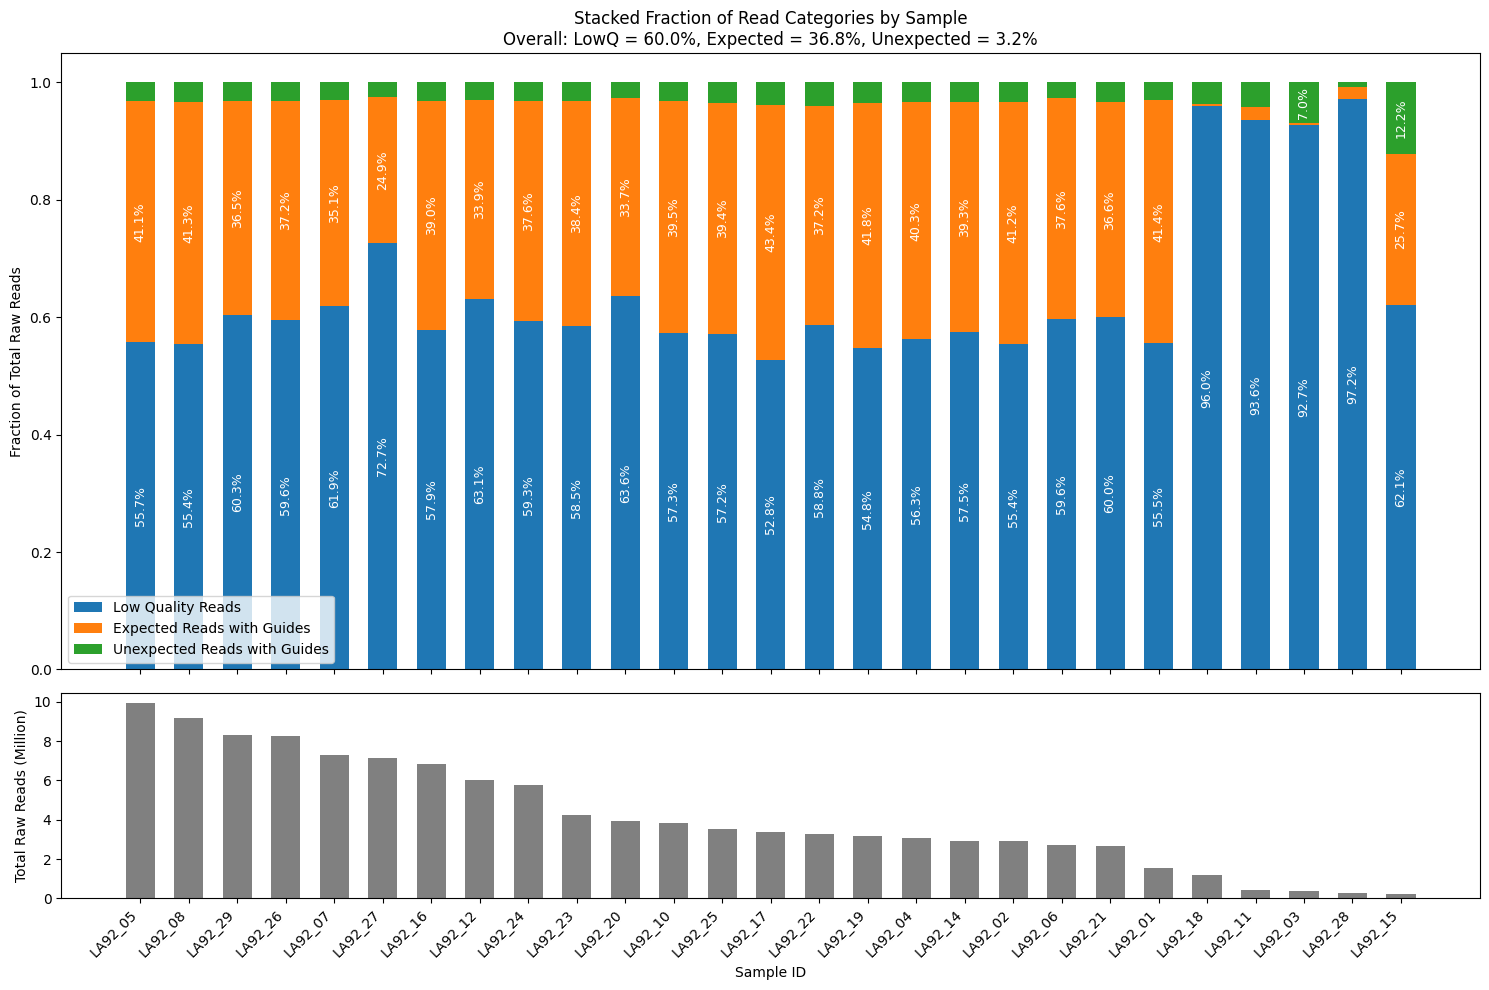

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Sort dataframe by total_raw_reads (descending)
raw_read_input_sorted = raw_read_input.sort_values(by='total_raw_reads', ascending=False).reset_index(drop=True)

# Compute overall fractions
overall_total = raw_read_input_sorted['total_raw_reads'].sum()
overall_lowq = raw_read_input_sorted['lowQ_reads'].sum()
overall_expected = raw_read_input_sorted['expected_reads_with_guides'].sum()
overall_unexpected = raw_read_input_sorted['unexpected_reads_with_guides'].sum()

overall_frac_lowq = overall_lowq / overall_total
overall_frac_expected = overall_expected / overall_total
overall_frac_unexpected = overall_unexpected / overall_total

# X positions
x = np.arange(len(raw_read_input_sorted))
bar_width = 0.6

# Fraction arrays
f_lowq = raw_read_input_sorted['frac_lowQ_reads'].values
f_expected = raw_read_input_sorted['frac_expected'].values
f_unexpected = raw_read_input_sorted['frac_unexpected'].values

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Upper panel: Stacked fraction plot
ax1.bar(x, f_lowq, width=bar_width, label='Low Quality Reads')
ax1.bar(x, f_expected, width=bar_width, bottom=f_lowq, label='Expected Reads with Guides')
ax1.bar(x, f_unexpected, width=bar_width, bottom=f_lowq + f_expected, label='Unexpected Reads with Guides')

# Annotate percentages with 90-degree rotation
for i in range(len(raw_read_input_sorted)):
    lowq_val = f_lowq[i]
    expected_val = f_expected[i]
    unexpected_val = f_unexpected[i]

    if lowq_val > 0.05:
        ax1.text(x[i], lowq_val / 2, f"{lowq_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
    if expected_val > 0.05:
        ax1.text(x[i], lowq_val + expected_val / 2, f"{expected_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
    if unexpected_val > 0.05:
        ax1.text(x[i], lowq_val + expected_val + unexpected_val / 2, f"{unexpected_val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)

ax1.set_ylabel('Fraction of Total Raw Reads')
ax1.set_title(
    f"Stacked Fraction of Read Categories by Sample\n"
    f"Overall: LowQ = {overall_frac_lowq:.1%}, Expected = {overall_frac_expected:.1%}, Unexpected = {overall_frac_unexpected:.1%}"
)
ax1.legend()

# Lower panel: Total reads bar plot
ax2.bar(x, raw_read_input_sorted['total_raw_reads'].values / 1e6, width=bar_width, color='gray')
ax2.set_ylabel('Total Raw Reads (Million)')
ax2.set_xlabel('Sample ID')

# Set x-axis labels
ax2.set_xticks(x)
ax2.set_xticklabels(raw_read_input_sorted['Sample_ID'], rotation=45, ha='right')

plt.tight_layout()

# Save figure if needed
plt.savefig(fig_output_address, format='pdf')

plt.show()


In [30]:
fig_output_address

'/labs/mwinslow/Haiqing/UltraSeq_Projects/Kat7_dual_guide_tumor/01_data_collection/data/sorted_read_fractions_and_totals.pdf'

## 6 Output  data

In [ ]:
# raw_read_input = pd.read_csv(summary_df_output_address)

In [26]:
raw_read_input.to_csv(summary_df_output_address,index=False)